In [1]:
import geopandas as gpd
from glob import glob
import matplotlib.pyplot as plt
import os
import rioxarray as rio
import xarray as xr
from dem_utils import ArcticDEM
from itertools import product
import dask
from dask.distributed import LocalCluster, Client
import numpy as np
import pandas as pd
import utils
from shapely import wkt
import cartopy.crs as ccrs
import planetary_computer as pc
import pystac_client
from pystac.extensions.eo import EOExtension as eo
import rioxarray as rio
import stackstac
import shapely

In [2]:
dems = glob('../data/id11*/*/padded*.tif')
masks = glob('../data/id11*/*/mask*.tif')
stacked_f = glob('../data/id11*/stacked_*')
sec_f = glob('../data/id11*/sec.zarr')
line = glob('../data/id11*/*.geojson')[0]
line = gpd.read_file(line).loc[0,'geometry']
bounds = line.buffer(5000).bounds

In [3]:
with LocalCluster() as cluster, cluster.get_client() as client:
    lazy = ArcticDEM.mask_stable_terrain('../data/id11_497441x_-1338620y/')
    dask.compute(lazy)

/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/s1759665/micromamba/envs/pape

In [5]:
ds = rio.open_rasterio('../data/id11_497441x_-1338620y/mask.tif')

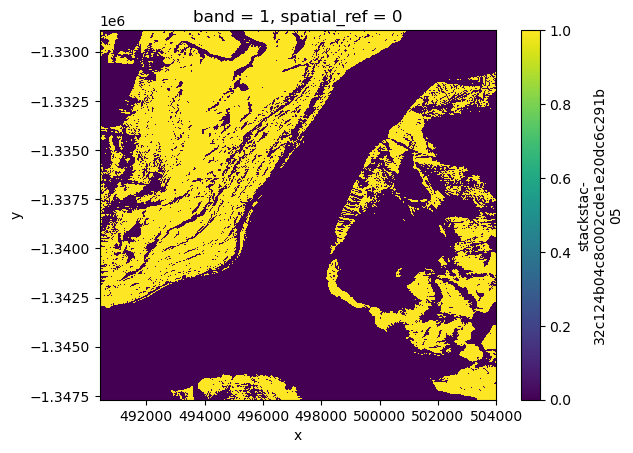

In [7]:
ds.plot()

In [ ]:
aaoi_4326 = utils.misc.shapely_reprojector(shapely.box(*bounds),
                                          3413,
                                          4326)

In [ ]:
_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace
    )

_search = _catalog.search(collections=['sentinel-2-l2a'],
                          intersects=aoi_4326,
                          datetime='2012-01-01/2025-01-01',
                          query={"eo:cloud_cover": {"lt": 10}})

_items = _search.item_collection()
_items = [i for i in _items if pd.to_datetime(i.properties['datetime']).month in [7,8]]
# _items = [i for i in _items if shapely.geometry.shape(i.geometry).contains(aoi_4326)]

In [ ]:
imgstack['id'].data.tolist()

In [ ]:
imgstack = stackstac.stack(_items,
                           assets=['B03', 'B08'],
                           epsg=3413).rio.clip_box(*bounds)
median_ndwi = (
    (imgstack[:,0,:,:] - imgstack[:,1,:,:]) / 
    (imgstack[:,0,:,:] + imgstack[:,1,:,:])
    ).median(dim='time').compute()

In [ ]:
fig, ax = plt.subplots()
(median_ndwi < 0).plot(ax=ax)
ax.plot(*line.coords.xy)

In [ ]:
ndwi = 

In [ ]:
ds = xr.open_dataset(sec_f, engine='zarr')
line = wkt.loads(ds.attrs['centreline'])

In [ ]:
prj = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70
    )

In [ ]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection':prj})

ds['n'].plot(ax=axs[0])

ds['sec'].sel(result='slope').plot(robust=True, cmap='RdBu', ax=axs[1])

for ax in axs:
    ax.plot(*line.coords.xy, c='k')
    

In [ ]:
points = [line.interpolate(i, normalized=True)
                for i in np.arange(0, 1, 0.01)]
cumul_dist = [line.project(p) for p in points]

In [ ]:
def sample_along_line(line, ds):
    

In [ ]:
with warnings.catch_warnings(action='ignore'):
    x = np.array([0,0,0,0])
    y = np.array([1,8,5,11])
    theilslopes(y, x)

In [ ]:
demstack.attrs = {
    'processed by': 'tlohde',
    'processed on': pd.Timestamp.now().strftime('%Y/%m/%d %H:%M'),
    'centreline': gpd.read_file('../data/id1_6685x_-3188046y/line_6685x_-3188046y.geojson').loc[0,'geometry'].wkt
}

In [ ]:
ds = xr.open_dataset('../data/id1_6685x_-3188046y/stacked_coregd.zarr/', engine='zarr')

In [ ]:
pf = ds['z'].polyfit(dim='time', deg=1)

## velocity

In [ ]:
from dask.distributed import Client, LocalCluster
import pandas as pd
# import itslive
import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely import box
import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from matplotlib.dates import date2num, DateFormatter, YearLocator
# import seaborn as sns
# import xrspatial as xrs
import numpy as np
import xarray as xr
from tqdm import tqdm
from IPython import display
import importlib
# import imagery
import utils
import velocity_helpers

In [ ]:
# _ = importlib.reload(utils)
# _ = importlib.reload(velocity_helpers)
# _ = importlib.reload(imagery)

In [ ]:
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

In [ ]:
## read in lines, and lazily get velocity cubes, centrelines, and robust trends
lines = gpd.read_file('../data/streams_v2.geojson').to_crs(3413)

In [ ]:
V = {}
failed = []
for row in tqdm(lines.sample(3).itertuples()):
    print(f'working on #{row.Index}')
    try:
        V[row.Index] = velocity_helpers.CentreLiner(
            geo=row.geometry,
            buff_dist=500,
            index=row.Index,
            filter_cube=False,
            get_robust_trend=True,
            get_annual_median=False,
            get_rgb=False,
            )
    except Exception as e:
        failed.append((row.Index, e))
        print(f'#{row.Index} did not work because\n{e}')
        continue

## plotting

In [ ]:
fig, axs = plt.subplots(figsize=[15,8],
                        nrows=2,
                        ncols=4,
                        sharex=True,
                        sharey=True)

for k_v, ax in zip(V.items(), axs.flat):
    k, v = k_v
    velocity_helpers.Plotters.rolling_median(v,
                                             ax=ax,
                                         **{'var': 'v',
                                            'ddt_range': ('335d','395d'),
                                            'ddt_bars': False,
                                            'col': 'cumul_dist',
                                            'window': '90d',
                                            'vals':[500, 1_000, 3_000, 5_000]
                                            })
    _point = utils.shapely_reprojector(v.point, 3413, 4326)
    
    ax.set_title(f'#{k}: {_point.y:.2f}N {_point.x:.2f}W\n{lines.loc[k,"name"]}')
    ax.minorticks_off()

# axs.flat[-2].remove()
axs.flat[-1].remove()

now = pd.Timestamp.now().strftime('%y%m%d_%H%M')+ '_'
directory = '../../GitHub/diary/journal_figures'
filename = 'iceland_outlets_annual_v.png'
fig.savefig(directory + now + filename, bbox_inches = 'tight')

In [ ]:
def centreline_theil_slopes(df, **kwargs):
    
    _var = kwargs.get('var', 'v')
    _x = kwargs.get('x', 'mid_date')
    _date_range = kwargs.get('date_range', (pd.Timestamp('1900-01-01'),
                                            pd.Timestamp.now()))
    _ddt_range = kwargs.get('ddt_range', ('0d', '30d'))
    _mad = kwargs.get('mad', 3)
    
    _df = df.loc[df[_x].between(*_date_range)]    

In [ ]:
idx = ((ds['date_dt'] > pd.Timedelta('335d')) & ((ds['date_dt'] <= pd.Timedelta('395d')))).compute()

from scipy.stats.mstats import theilslopes
from scipy.stats import linregress

x = (ds.mid_date[idx] - ds.mid_date[idx].min()) / pd.Timedelta('365.25d')
y = ds['v'][idx,50,50].compute()

nan_idx = y.isnull()

x = x[~nan_idx]
y= y[~nan_idx]

theil_result = theilslopes(y=y, x=x)
lr_result = linregress(x=x, y=y)


X = np.arange(0,30)
theil_fit = (X * theil_result.slope) + theil_result.intercept
lr_fit = (X * lr_result.slope) + lr_result.intercept

fig, ax = plt.subplots()
ax.scatter(x,y)

ax.plot(X, theil_fit, c='r', label='theilslopes')
ax.plot(X, lr_fit, c='g', label='lr')
ax.legend()

In [ ]:
fig, axs = plt.subplots(figsize=[15,8], nrows=5, ncols=3)
# get_velocity.Plotters.date_dt_bars(V[13],
#                                    ('1d','15d'),
#                                    ax=ax,
#                                    **{'vals':[5_000,1_000]})

get_velocity.Plotters.rolling_median(V[13],
                                     ('335d','395d'),
                                     ax=ax,
                                     ddt_bars=False,
                                     **{'var': 'v',
                                        'col': 'cumul_dist',
                                        'window': '180d',
                                        'vals':[1_000, 3_000, 5_000, 10_000]})

- look at underlying dodgy velocity images
TODO look at GRIMpP and MEASUREs

TODO
- PN thinks that relative change is sufficient to *control* for variations in glacier geometry (read: width/size).
- most interested in *relative* change of velocity over final few kilometers.
    - i.e. 

- it all comes from the same raw processed v data

## imagery

In [ ]:
study_sites = gpd.read_file('../data/potential_study_sites_v1.geojson')
study_sites = study_sites.loc[study_sites['notes'].isin(['yes', 'maybe'])]
study_sites.reset_index(drop=True, inplace=True)
study_sites_5k = study_sites.buffer(5_000).to_crs(4326)

In [ ]:
items = imagery.get_annual_median_mosaic(
    study_sites.loc[0,'geometry'],
    buffer_dist=15_000,
    src_crs=study_sites.crs,
    target_crs=4326,
    timeperiod='2023-01-01/2024-01-01',
    months=[8,9],
    )

In [ ]:
(xrs.multispectral.true_color(
    *items.squeeze()
    .transpose('band', 'y', 'x'))
 .plot.imshow(rgb='band')
)

In [ ]:
import stackstac
stackstac.stack(items, assets=['B04', 'B03', 'B02'])